> *Half a million children become ill with TB each year. There are 10 million children worldwide who had been orphaned because a parent died of TB.*<br>
> *Basic diagnosis of TB has not changed for more than a century. New genetic tests for TB make it possible to rapidly identify people who need TB treatment. But a simple quick test of the sort already available for diseases like HIV and malaria is needed urgently.* <br>
>*** ~ stoptb.org***

**Introduction**

In this kernel we will build a model that can look at a chest x-ray and predict whether a person has TB or not. The model will be trained on a dataset of 800 images from two sources:

- Shenzhen, China (Folder: ChinaSet_AllFiles)
- Montgomery, USA (Folder: Montgomery)

**Results:**

The dataset is quite small but by using a CNN and data augmentation, the final accuracy and F1 score that we get will be greater than 0.8. Because we need to use as many images as possible for training, the validation set will contain only 120 images. This is 15% of the data.

With a small dataset and a very small validation set, will this model generalize well? I don't really know. However, I've deployed the model as a Tensorflowjs web app so it can be tested. Using a web app is one way that a tool like this could - quickly and cheaply - be put in the hands of medical personnel that need it.

***


All the html, css and javascript code used to build the app is available on Github.<br>

Web App:<br>
http://tb.test.woza.work/<br>
Github:<br>
https://github.com/vbookshelf/Tuberculosis-TB-Analyzer






In [3]:
from numpy.random import seed
seed(101)
from tensorflow import set_random_seed
set_random_seed(101)

import pandas as pd
import numpy as np

import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import binary_accuracy

import os
import cv2

import imageio
import skimage
import skimage.io
import skimage.transform

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Total number of images we want to have in each class
NUM_AUG_IMAGES_WANTED = 1000 

# We will resize the images
IMAGE_HEIGHT = 96
IMAGE_WIDTH = 96

### What files are available?

In [5]:
os.listdir('../input')

['ChinaSet_AllFiles', 'Montgomery']

### What are the labels?


The label is part of the file name.

Example: *CHNCXR_0470__**1**.png*<br>

**0** = Normal (No TB)<br>
**1** = TB<br>

Each of the two datasets has a text file containing meta-data.

### How many images are in each folder?
Note: In both the Mongomery and Shenzhen folders there is a non image file called 'Thumbs.db'

In [6]:
print(len(os.listdir('../input/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png')))
print(len(os.listdir('../input/Montgomery/MontgomerySet/CXR_png')))

663
139


### Create a Dataframe containing all images

In [7]:
shen_image_list = os.listdir('../input/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png')
mont_image_list = os.listdir('../input/Montgomery/MontgomerySet/CXR_png')

In [8]:
# put the images into dataframes
df_shen = pd.DataFrame(shen_image_list, columns=['image_id'])
df_mont = pd.DataFrame(mont_image_list, columns=['image_id'])

# remove the 'Thunbs.db' line
df_shen = df_shen[df_shen['image_id'] != 'Thumbs.db']
df_mont = df_mont[df_mont['image_id'] != 'Thumbs.db']

# Reset the index or this will cause an error later
df_shen.reset_index(inplace=True, drop=True)
df_mont.reset_index(inplace=True, drop=True)

print(df_shen.shape)
print(df_mont.shape)

(662, 1)
(138, 1)


In [9]:
df_shen.head()

,image_id
0,CHNCXR_0092_0.png
1,CHNCXR_0322_0.png
2,CHNCXR_0304_0.png
3,CHNCXR_0572_1.png
4,CHNCXR_0547_1.png


In [10]:
df_mont.head()

,image_id
0,MCUCXR_0017_0.png
1,MCUCXR_0020_0.png
2,MCUCXR_0030_0.png
3,MCUCXR_0013_0.png
4,MCUCXR_0354_1.png


### Assign labels to the images

In [11]:
# Function to select the 4th index from the end of the string (file name)
# example: CHNCXR_0470_1.png --> 1 is the label, meaning TB is present.

def extract_target(x):
    target = int(x[-5])
    if target == 0:
        return 'Normal'
    if target == 1:
        return 'Tuberculosis'

In [12]:
# Assign the target labels

df_shen['target'] = df_shen['image_id'].apply(extract_target)

df_mont['target'] = df_mont['image_id'].apply(extract_target)


### Check the class distribution

In [13]:
# Shenzen Dataset

df_shen['target'].value_counts()

Tuberculosis    336
Normal          326
Name: target, dtype: int64

In [14]:
# Montgomery Dataset

df_mont['target'].value_counts()

Normal          80
Tuberculosis    58
Name: target, dtype: int64

### Display a ramdom sample of images from each dataset by target

In [15]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['image_id']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=14)  
    plt.tight_layout()
    plt.show()
    

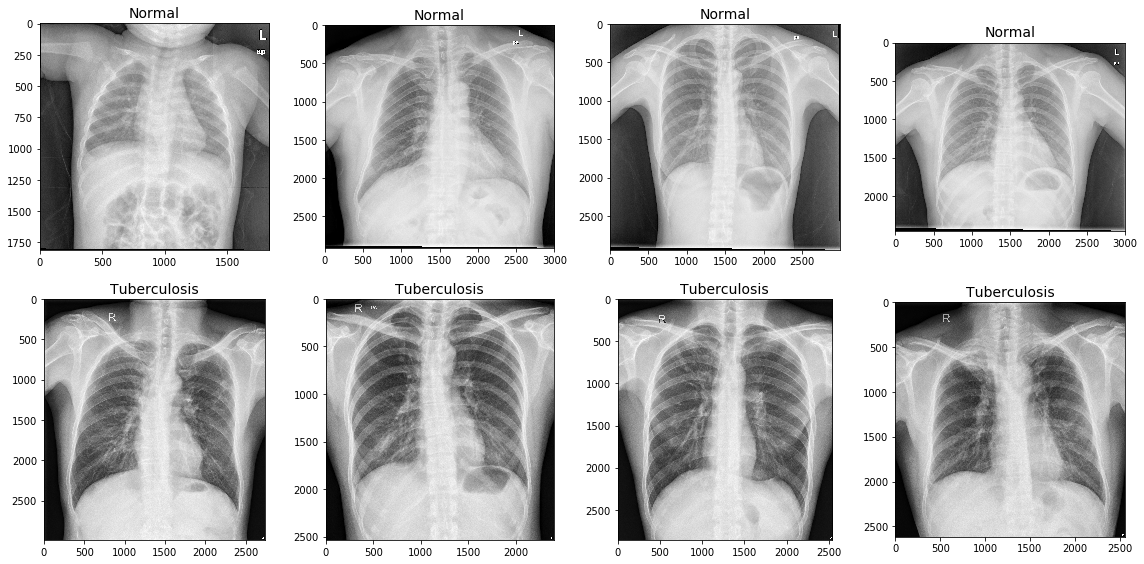

In [16]:
# Shenzen Dataset

IMAGE_PATH = '../input/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/' 

draw_category_images('target',4, df_shen, IMAGE_PATH)

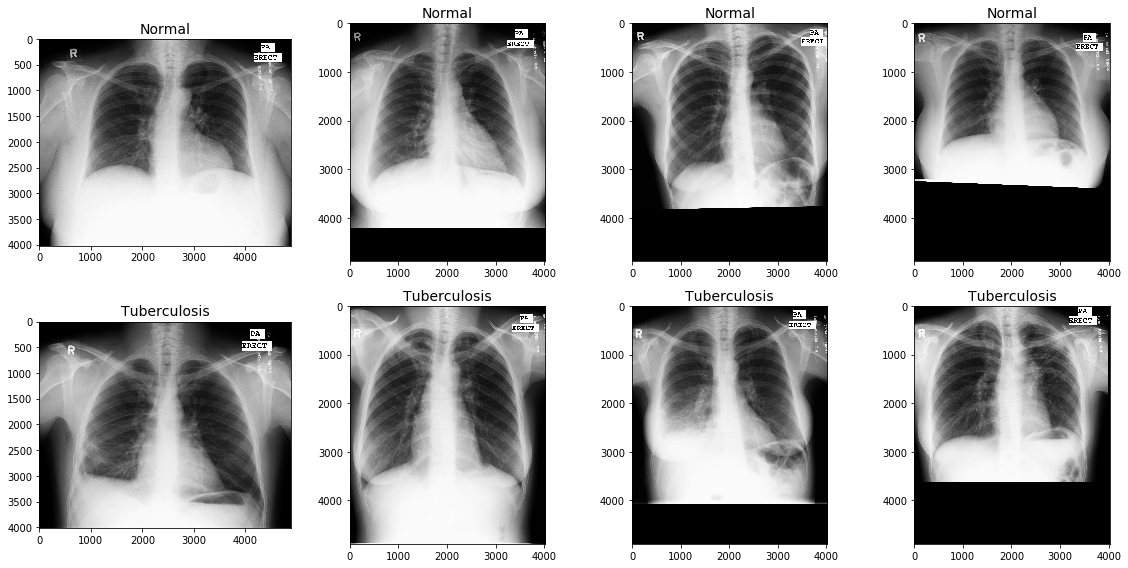

In [17]:
# Montgomery Dataset

IMAGE_PATH = '../input/Montgomery/MontgomerySet/CXR_png/'

draw_category_images('target',4, df_mont, IMAGE_PATH)

### What is the shape of each image and what are its max and min pixel values?
Let's include all this info in the dataframes we created above.

In [18]:
def read_image_sizes(file_name):
    """
    1. Get the shape of the image
    2. Get the min and max pixel values in the image.
    Getting pixel values will tell if any pre-processing has been done.
    3. This info will be added to the original dataframe.
    """
    image = cv2.imread(IMAGE_PATH + file_name)
    max_pixel_val = image.max()
    min_pixel_val = image.min()
    
    # image.shape[2] represents the number of channels: (height, width, num_channels).
    # Here we are saying: If the shape does not have a value for num_channels (height, width)
    # then assign 1 to the number of channels.
    if len(image.shape) > 2: # i.e. more than two numbers in the tuple
        output = [image.shape[0], image.shape[1], image.shape[2], max_pixel_val, min_pixel_val]
    else:
        output = [image.shape[0], image.shape[1], 1, max_pixel_val, min_pixel_val]
    return output



In [19]:
IMAGE_PATH = '../input/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/'

m = np.stack(df_shen['image_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val'])
df_shen = pd.concat([df_shen,df],axis=1, sort=False)

df_shen.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val
0,CHNCXR_0092_0.png,Normal,2652,2796,3,255,0
1,CHNCXR_0322_0.png,Normal,2949,3000,3,255,0
2,CHNCXR_0304_0.png,Normal,2945,3000,3,255,0
3,CHNCXR_0572_1.png,Tuberculosis,2289,2400,3,255,0
4,CHNCXR_0547_1.png,Tuberculosis,2823,2610,3,255,0


In [20]:
IMAGE_PATH = '../input/Montgomery/MontgomerySet/CXR_png/'

m = np.stack(df_mont['image_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val'])
df_mont = pd.concat([df_mont,df],axis=1, sort=False)

df_mont.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val
0,MCUCXR_0017_0.png,Normal,4020,4892,3,255,0
1,MCUCXR_0020_0.png,Normal,4020,4892,3,255,0
2,MCUCXR_0030_0.png,Normal,4020,4892,3,255,0
3,MCUCXR_0013_0.png,Normal,4020,4892,3,255,0
4,MCUCXR_0354_1.png,Tuberculosis,4020,4892,3,252,0


### How many channels do the images in each dataset have?

In [21]:
df_shen['c'].value_counts()

3    662
Name: c, dtype: int64

In [22]:
df_mont['c'].value_counts()

3    138
Name: c, dtype: int64

We see that all images have 3 channels.

### Create the Train and Val Sets

In [23]:
df_mont['target'].value_counts()

Normal          80
Tuberculosis    58
Name: target, dtype: int64

In [24]:
### Combine the two dataframes and shuffle

df_data = pd.concat([df_shen, df_mont], axis=0).reset_index(drop=True)

df_data = shuffle(df_data)


df_data.shape

(800, 7)

In [25]:
# Create a new column called 'labels' that maps the classes to binary values.
df_data['labels'] = df_data['target'].map({'Normal':0, 'Tuberculosis':1})

In [26]:
df_data.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val,labels
679,MCUCXR_0144_1.png,Tuberculosis,4892,4020,3,255,0,1
177,CHNCXR_0566_1.png,Tuberculosis,2998,2573,3,255,0,1
60,CHNCXR_0098_0.png,Normal,2951,3000,3,255,0,0
782,MCUCXR_0021_0.png,Normal,4892,4020,3,255,0,0
667,MCUCXR_0044_0.png,Normal,4892,4020,3,255,0,0


In [27]:
# train_test_split

y = df_data['labels']

df_train, df_val = train_test_split(df_data, test_size=0.15, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(680, 8)
(120, 8)


In [28]:
df_train['target'].value_counts()

Normal          345
Tuberculosis    335
Name: target, dtype: int64

In [29]:
df_val['target'].value_counts()

Normal          61
Tuberculosis    59
Name: target, dtype: int64

### Create a Directory Structure

In [30]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train
    # Normal
    # Tuberculosis

# val
    # Normal
    # Tuberculosis


# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
Normal = os.path.join(train_dir, 'Normal')
os.mkdir(Normal)
Tuberculosis = os.path.join(train_dir, 'Tuberculosis')
os.mkdir(Tuberculosis)


# create new folders inside val_dir
Normal = os.path.join(val_dir, 'Normal')
os.mkdir(Normal)
Tuberculosis = os.path.join(val_dir, 'Tuberculosis')
os.mkdir(Tuberculosis)


### Transfer the images into the folders

In [31]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [32]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('../input/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png')
folder_2 = os.listdir('../input/Montgomery/MontgomerySet/CXR_png')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:
    
    fname = image
    label = df_data.loc[image,'target']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('../input/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        #shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('../input/Montgomery/MontgomerySet/CXR_png', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    fname = image
    label = df_data.loc[image,'target']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('../input/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('../input/Montgomery/MontgomerySet/CXR_png', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)

In [33]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/Normal')))
print(len(os.listdir('base_dir/train_dir/Tuberculosis')))


345
335


In [34]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/Normal')))
print(len(os.listdir('base_dir/val_dir/Tuberculosis')))


61
59


### Copy the train images into aug_dir
aug_dir is where we temporarily store images from a given class before feeding them into the generator for augmentation.¶

We will not be augmenting on the fly. We will create augmented images, store them in folders together with the raw images and then feed these into the generators. I found that working this way makes the training process run faster.

In [35]:
class_list = ['Normal','Tuberculosis']

for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later.
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'Normal'
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='png',
                                                    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                                    batch_size=batch_size)
    
    
    # Generate the augmented images and add them to the training folders
    
    
    num_files = len(os.listdir(img_dir))
    
    # this creates a similar amount of images for each class
    num_batches = int(np.ceil((NUM_AUG_IMAGES_WANTED-num_files)/batch_size))

    # run the generator and create augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 345 images belonging to 1 classes.
Found 335 images belonging to 1 classes.


In [36]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir('base_dir/train_dir/Normal')))
print(len(os.listdir('base_dir/train_dir/Tuberculosis')))

1035
1005


In [37]:
# Check how many val images we have in each folder.

print(len(os.listdir('base_dir/val_dir/Normal')))
print(len(os.listdir('base_dir/val_dir/Tuberculosis')))

61
59


### Visualize a batch of augmented images

In [38]:
# plots images with labels within jupyter notebook
# source: https://github.com/smileservices/keras_utils/blob/master/utils.py

def plots(ims, figsize=(20,10), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        


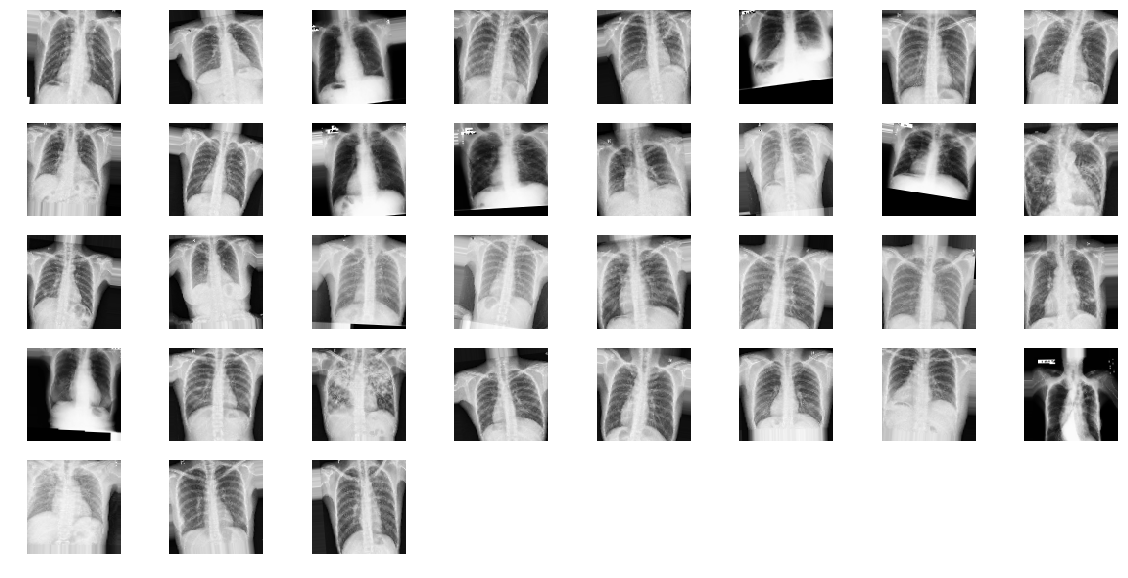

In [39]:
plots(imgs, titles=None) # titles=labels will display the image labels

In [40]:
# End of Data Preparation
### ===================================================================================== ###
# Start of Model Building


### Set Up the Generators

In [41]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [42]:

datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical',
                                        shuffle=False)

Found 2040 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


### Create the Model Architecture

In [43]:
# Source: https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-5min-0-8253-lb

kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 43, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 41, 41, 64)        36928     
__________

### Train the Model

In [44]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [45]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                            validation_data=val_gen,
                            validation_steps=val_steps,
                            epochs=100, verbose=1,
                           callbacks=callbacks_list)

Epoch 1/100
67/68 [============================>.] - ETA: 0s - loss: 0.6947 - acc: 0.5284
Epoch 00001: val_acc improved from -inf to 0.49167, saving model to model.h5
68/68 [==============================] - 33s 485ms/step - loss: 0.6946 - acc: 0.5265 - val_loss: 0.6928 - val_acc: 0.4917
Epoch 2/100
67/68 [============================>.] - ETA: 0s - loss: 0.6943 - acc: 0.4925
Epoch 00002: val_acc improved from 0.49167 to 0.49167, saving model to model.h5
68/68 [==============================] - 31s 452ms/step - loss: 0.6943 - acc: 0.4897 - val_loss: 0.6929 - val_acc: 0.4917
Epoch 3/100
67/68 [============================>.] - ETA: 0s - loss: 0.6902 - acc: 0.5224
Epoch 00003: val_acc improved from 0.49167 to 0.50833, saving model to model.h5
68/68 [==============================] - 31s 450ms/step - loss: 0.6903 - acc: 0.5206 - val_loss: 0.6914 - val_acc: 0.5083
Epoch 4/100
67/68 [============================>.] - ETA: 0s - loss: 0.6961 - acc: 0.4851
Epoch 00004: val_acc did not improve 

### Evaluate the model using the val set

In [46]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'acc']

In [47]:
# Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_acc = \
model.evaluate_generator(test_gen, 
                        steps=val_steps)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

val_loss: 0.505658894777298
val_acc: 0.7999999970197678


### Plot the Training Curves

<Figure size 432x288 with 0 Axes>

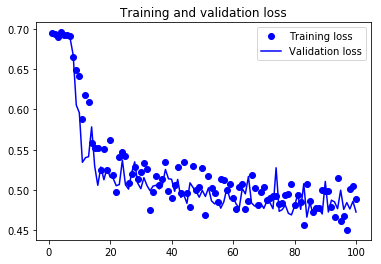

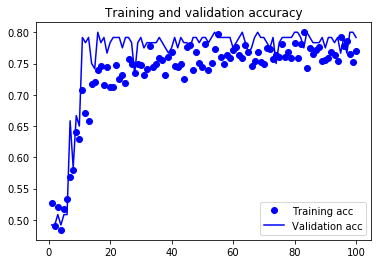

<Figure size 432x288 with 0 Axes>

In [48]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

### Create a Confusion Matrix

In [49]:
# Get the labels of the test images.

test_labels = test_gen.classes

In [50]:
# We need these to plot the confusion matrix.
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [51]:
# Print the label associated with each class
test_gen.class_indices

{'Normal': 0, 'Tuberculosis': 1}

In [52]:
# make a prediction
predictions = model.predict_generator(test_gen, steps=val_steps, verbose=1)

12/12 [==============================] - 2s 168ms/step


In [53]:
predictions.shape

(120, 2)

In [54]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [55]:
test_labels.shape

(120,)

In [56]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [57]:
test_gen.class_indices

{'Normal': 0, 'Tuberculosis': 1}

Confusion matrix, without normalization
[[51 10]
 [14 45]]


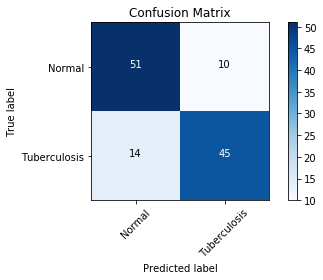

In [58]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['Normal', 'Tuberculosis']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Create a Classification Report

In [59]:
# Get the filenames, labels and associated predictions

# This outputs the sequence in which the generator processed the test images
test_filenames = test_gen.filenames

# Get the true labels
y_true = test_gen.classes

# Get the predicted labels
y_pred = predictions.argmax(axis=1)

In [60]:
from sklearn.metrics import classification_report

# Generate a classification report

report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)


              precision    recall  f1-score   support

      Normal       0.78      0.84      0.81        61
Tuberculosis       0.82      0.76      0.79        59

 avg / total       0.80      0.80      0.80       120



**Recall **= Given a class, will the classifier be able to detect it?<br>
**Precision** = Given a class prediction from a classifier, how likely is it to be correct?<br>
**F1 Score** = The harmonic mean of the recall and precision. Essentially, it punishes extreme values.

The F1 score is greater than 0.8. From the confusion matrix we see that our model has a  tendency to classify TB images as Normal, more so than to classify Normal images as TB. 

**Reference Kernels:**

I found the following kernels very helpful:

1. Gabriel Preda, Honey Bee Subspecies Classification<br>
https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

2. Francesco Marazzi, Baseline Keras CNN<br>
https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-5min-0-8253-lb

**Conclusion**

Many thanks to Kevin Mader for making this dataset available on Kaggle.

Thank you for reading.